In [125]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Upload Datasets

In [126]:
interactions_train = pd.read_csv('../data/raw/interactions_train.csv')
items = pd.read_csv('../data/raw/items.csv')
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')

In [127]:
print(interactions_train['i'].isin(items['i']).mean())

1.0


Since it returns 1.0, we know that "i" is indeed the item/book ID.

Let's rename our columns for more clarity

In [128]:
items = items.rename(columns={'i': 'item_id'})
items.head()

,Title,Author,ISBN Valid,Publisher,Subjects,item_id
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


In [129]:
interactions_train = interactions_train.rename(columns={
    'u': 'user_id',
    'i': 'item_id',
    't': 'timestamp'
})
interactions_train.head()

,user_id,item_id,timestamp
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


### Remove duplicates

In [130]:
#check duplicates interactions
print('\n>>> Duplicates in interactions:\n',interactions_train.duplicated().sum())
#check duplicates items
print('\n>>> Duplicates in items:\n',items.duplicated().sum())



>>> Duplicates in interactions:
 2

>>> Duplicates in items:
 0


In [131]:
#drop duplicates
interactions_train.drop_duplicates(inplace=True)
print('\n>>> Duplicates in interactions:\n',interactions_train.duplicated().sum())


>>> Duplicates in interactions:
 0


# 1. interaction_train

In [132]:
print("Shape: ",interactions_train.shape)
interactions_train.head()


Shape:  (87045, 3)


,user_id,item_id,timestamp
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


### add datetime

In [133]:
# First, convert your timestamp column to pandas datetime format
interactions_train['datetime'] = pd.to_datetime(interactions_train['timestamp'], unit='s')

# Extract and fill year, month, day, and weekday
interactions_train['year'] = interactions_train['datetime'].dt.year
interactions_train['month'] = interactions_train['datetime'].dt.month
interactions_train['day'] = interactions_train['datetime'].dt.day
interactions_train['day_of_week'] = interactions_train['datetime'].dt.dayofweek


In [134]:
interactions_train.head()

,user_id,item_id,timestamp,datetime,year,month,day,day_of_week
0,4456,8581,1.687541e+09,2023-06-23 17:24:46,2023,6,23,4
1,142,1964,1.679585e+09,2023-03-23 15:30:06,2023,3,23,3
2,362,3705,1.706872e+09,2024-02-02 11:00:59,2024,2,2,4
3,1809,11317,1.673533e+09,2023-01-12 14:19:22,2023,1,12,3
4,4384,1323,1.681402e+09,2023-04-13 16:09:22,2023,4,13,3


In [135]:
interactions_train.head()

,user_id,item_id,timestamp,datetime,year,month,day,day_of_week
0,4456,8581,1.687541e+09,2023-06-23 17:24:46,2023,6,23,4
1,142,1964,1.679585e+09,2023-03-23 15:30:06,2023,3,23,3
2,362,3705,1.706872e+09,2024-02-02 11:00:59,2024,2,2,4
3,1809,11317,1.673533e+09,2023-01-12 14:19:22,2023,1,12,3
4,4384,1323,1.681402e+09,2023-04-13 16:09:22,2023,4,13,3


**Solution** → We will implement **timestamp-aware modeling** through *chronological train/test splits* and *recency-weighted interactions* to ensure recommendations reflect evolving user preferences rather than historical patterns. This will be done in the dataloader

# 2. items

`items.csv` – metadata for each item (title, author, subjects, etc.)

In [136]:
print(items.shape)
items.head()

(15291, 6)


,Title,Author,ISBN Valid,Publisher,Subjects,item_id
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


### Drop column that are not needed for modeling

In [137]:
items.drop(columns=['ISBN Valid'], inplace=True)
items.head()

,Title,Author,Publisher,Subjects,item_id
0,Classification décimale universelle : édition ...,NaN,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


### Fill NaN values

In [138]:
# Fill NaN in 'Subjects' with "Unknown Subjects"
items['Subjects'] = items['Subjects'].fillna("Unknown Subjects")

# Fill NaN in 'Author' with "Unknown Author"
items['Author'] = items['Author'].fillna("Unknown Author")

# Fill NaN in 'Publisher' with "Unknown Publisher"
items['Publisher'] = items['Publisher'].fillna("Unknown Publisher")


In [139]:
items.head(10)

,Title,Author,Publisher,Subjects,item_id
0,Classification décimale universelle : édition ...,Unknown Author,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,Unknown Author,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4
5,100 idées pour mieux gérer les troubles de l'a...,"Lussier, Francine",Tom Pousse,Trouble déficitaire de l'attention avec ou san...,5
6,La boîte à outils des formateurs : 71 outils...,"Bouchut, Fabienne",Dunod,Formateurs (éducation des adultes)--Formation...,6
7,L'autorité éducative dans la classe : douze si...,"Robbes, Bruno",ESF éd,autorité--relation maître-élève; autorité--ens...,7
8,Un autre regard sur le climat /,Emma dessinatrice 1981-....,Massot,Climat--Détérioration; Bandes dessinées,8
9,Le mirage de la croissance verte /,"Auffret, Anthony",Delcourt,Développement économique--Aspect environnement...,9


### Normalize

from now use `items_normalize `

In [140]:
items_normalize = items.copy()
for col in items_normalize.columns:
    if items_normalize[col].dtype == "object":
        # Convert to string, lowercase, remove punctuation except semicolon, and strip whitespace
        items_normalize[col] = (
            items_normalize[col].astype(str)
            .str.lower()
            .str.replace(r'[^\w\s;]', '', regex=True)
            .str.replace(r'\s+', ' ', regex=True)
            .str.strip()
        )
items_normalize.head()

,Title,Author,Publisher,Subjects,item_id
0,classification décimale universelle édition ab...,unknown author,ed du cefal,classification décimale universelle; indexatio...,0
1,les interactions dans lenseignement des langue...,cicurel francine 1947,didier,didactiquelangue étrangère enseignement; didac...,1
2,histoire de vie et recherche biographique pers...,unknown author,lharmattan,histoires de vie en sociologie; sciences socia...,2
3,ce livre devrait me permettre de résoudre le c...,mazas sylvain 1980,vraoum,moyenorient; bandes dessinées autobiographique...,3
4,les années glorieuses roman,lemaitre pierre 1951,calmannlévy,france19451975; roman historique; roman frança...,4


## Separate subjects

display each subjects and occurance
->  `subject_counts_df `

In [141]:
# Create a new column with subjects as lists
items_normalize['Subjects_list'] = items_normalize['Subjects'].astype(str).str.split(';')

In [142]:

items_normalize.head()

,Title,Author,Publisher,Subjects,item_id,Subjects_list
0,classification décimale universelle édition ab...,unknown author,ed du cefal,classification décimale universelle; indexatio...,0,"[classification décimale universelle, indexat..."
1,les interactions dans lenseignement des langue...,cicurel francine 1947,didier,didactiquelangue étrangère enseignement; didac...,1,"[didactiquelangue étrangère enseignement, did..."
2,histoire de vie et recherche biographique pers...,unknown author,lharmattan,histoires de vie en sociologie; sciences socia...,2,"[histoires de vie en sociologie, sciences soc..."
3,ce livre devrait me permettre de résoudre le c...,mazas sylvain 1980,vraoum,moyenorient; bandes dessinées autobiographique...,3,"[moyenorient, bandes dessinées autobiographiq..."
4,les années glorieuses roman,lemaitre pierre 1951,calmannlévy,france19451975; roman historique; roman frança...,4,"[france19451975, roman historique, roman fra..."


In [143]:
# Explode the 'Subjects_list' column so each subject is in its own row
exploded_subjects = items_normalize.explode('Subjects_list')

# Lowercase and strip whitespace for normalization
exploded_subjects['Subjects_list'] = exploded_subjects['Subjects_list'].str.lower().str.strip()

# Count the occurrences and convert to a DataFrame
subject_counts_df = exploded_subjects['Subjects_list'].value_counts().reset_index()
subject_counts_df.columns = ['Subject', 'Count']

# Display the DataFrame
subject_counts_df

,Subject,Count
0,unknown subjects,2223
1,bandes dessinées,1045
2,schweiz,918
3,suisse,461
4,guides pratiques,401
...,...,...
22644,célébritéssuisse,1
22645,sondages dopinion,1
22646,formateurs education des adultesformation,1
22647,personnelformation,1


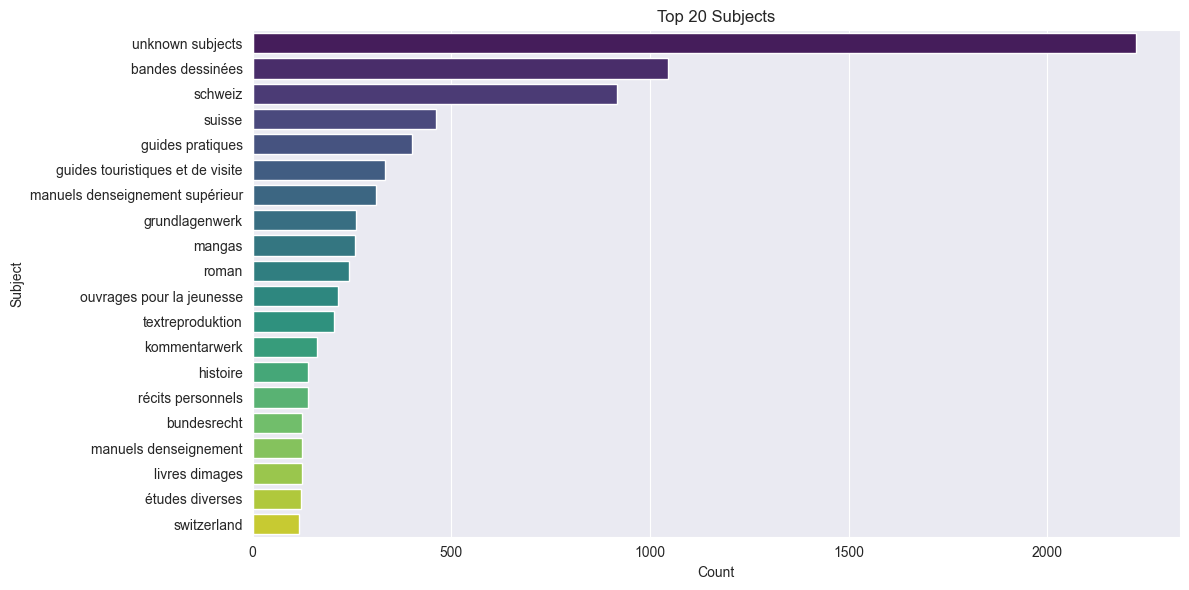

In [144]:
# Plot top 20 subjects
top_n = 20
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Count',
    y='Subject',
    data=subject_counts_df.head(top_n),
    palette='viridis',
    hue='Subject',
    legend=False
)
plt.title(f'Top {top_n} Subjects')
plt.xlabel('Count')
plt.ylabel('Subject')
plt.tight_layout()
plt.show()


# 3. Merge datasets
clean interaction: `interactions_clean`

clean items: `items_clean`


**-> merged dataframe: `df`**

-> dataframe sorted by Item id : `df_sorted_by_items`

In [145]:
interactions_clean = interactions_train.copy()
interactions_clean

,user_id,item_id,timestamp,datetime,year,month,day,day_of_week
0,4456,8581,1.687541e+09,2023-06-23 17:24:46,2023,6,23,4
1,142,1964,1.679585e+09,2023-03-23 15:30:06,2023,3,23,3
2,362,3705,1.706872e+09,2024-02-02 11:00:59,2024,2,2,4
3,1809,11317,1.673533e+09,2023-01-12 14:19:22,2023,1,12,3
4,4384,1323,1.681402e+09,2023-04-13 16:09:22,2023,4,13,3
...,...,...,...,...,...,...,...,...
87042,924,8171,1.699284e+09,2023-11-06 15:15:47,2023,11,6,0
87043,1106,9009,1.699872e+09,2023-11-13 10:48:13,2023,11,13,0
87044,5207,13400,1.683627e+09,2023-05-09 10:02:52,2023,5,9,1
87045,698,5779,1.686667e+09,2023-06-13 14:37:48,2023,6,13,1


In [146]:
items_clean = items_normalize.copy()
items_clean.head()

,Title,Author,Publisher,Subjects,item_id,Subjects_list
0,classification décimale universelle édition ab...,unknown author,ed du cefal,classification décimale universelle; indexatio...,0,"[classification décimale universelle, indexat..."
1,les interactions dans lenseignement des langue...,cicurel francine 1947,didier,didactiquelangue étrangère enseignement; didac...,1,"[didactiquelangue étrangère enseignement, did..."
2,histoire de vie et recherche biographique pers...,unknown author,lharmattan,histoires de vie en sociologie; sciences socia...,2,"[histoires de vie en sociologie, sciences soc..."
3,ce livre devrait me permettre de résoudre le c...,mazas sylvain 1980,vraoum,moyenorient; bandes dessinées autobiographique...,3,"[moyenorient, bandes dessinées autobiographiq..."
4,les années glorieuses roman,lemaitre pierre 1951,calmannlévy,france19451975; roman historique; roman frança...,4,"[france19451975, roman historique, roman fra..."


In [147]:
df = interactions_clean.merge(items_clean, on="item_id", how="left")

In [148]:
df

,user_id,item_id,timestamp,datetime,year,month,day,day_of_week,Title,Author,Publisher,Subjects,Subjects_list
0,4456,8581,1.687541e+09,2023-06-23 17:24:46,2023,6,23,4,ashes falling for the sky,gorman nine,albin michel,unknown subjects,[unknown subjects]
1,142,1964,1.679585e+09,2023-03-23 15:30:06,2023,3,23,3,la page blanche,boulet 1975,delcourt,bandes dessinées,[bandes dessinées]
2,362,3705,1.706872e+09,2024-02-02 11:00:59,2024,2,2,4,aysuun roman,manook ian,albin michel,vengeance; thriller roman,"[vengeance, thriller roman]"
3,1809,11317,1.673533e+09,2023-01-12 14:19:22,2023,1,12,3,le cercle des rêveurs éveillés,bardecabuçon olivier,gallimard,roman policier,[roman policier]
4,4384,1323,1.681402e+09,2023-04-13 16:09:22,2023,4,13,3,lexamen clinique de laîné guide dévaluation et...,voyer philippe,pearson,nursing care; geriatrics; health services for ...,"[nursing care, geriatrics, health services f..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87040,924,8171,1.699284e+09,2023-11-06 15:15:47,2023,11,6,0,différence souffrance de ladulte surdoué,bost cécile,vuibert,surdoués,[surdoués]
87041,1106,9009,1.699872e+09,2023-11-13 10:48:13,2023,11,13,0,replay mémoires dune famille,mechner jordan,delcourt,unknown subjects,[unknown subjects]
87042,5207,13400,1.683627e+09,2023-05-09 10:02:52,2023,5,9,1,vers une gestion éducative de la classe,archambault jean pédagogue,g morin,classes éducationconduite; psychologie de lapp...,"[classes éducationconduite, psychologie de la..."
87043,698,5779,1.686667e+09,2023-06-13 14:37:48,2023,6,13,1,a short history of the world in 50 lies,tidd natasha,michael omara books limited,unknown subjects,[unknown subjects]


In [149]:
# Sort DataFrame by user_id in ascending order
df_sorted_by_timestamp = df.sort_values(by='timestamp')

df_sorted_by_timestamp

,user_id,item_id,timestamp,datetime,year,month,day,day_of_week,Title,Author,Publisher,Subjects,Subjects_list
78826,2083,7521,1.672664e+09,2023-01-02 12:47:23,2023,1,2,0,lire et écrire un scénario fiction documentair...,raynauld isabelle,armand colin,cinémascénarios; émissions télévisées; cinémaa...,"[cinémascénarios, émissions télévisées, ciné..."
81705,2083,7517,1.672664e+09,2023-01-02 12:47:32,2023,1,2,0,ecrire pour le cinema les cles de la scenarisa...,billon pierre,editions somme toute,cinémaart décrire; scénarios; motion picture p...,"[cinémaart décrire, scénarios, motion pictur..."
50419,6861,12883,1.672682e+09,2023-01-02 18:00:33,2023,1,2,0,lecture accélérée de lecg pour un enseignement...,dubin dale,maloine,electrocardiography; programmed instruction,"[electrocardiography, programmed instruction]"
52559,4333,13176,1.672688e+09,2023-01-02 19:34:22,2023,1,2,0,a history of the ptolemaic empire,hölbl günther,routledge,egypte antiqueépoque ptolémaïque,[egypte antiqueépoque ptolémaïque]
36325,2754,10953,1.672735e+09,2023-01-03 08:41:53,2023,1,3,1,abrégé de droit civil art 1er à 640 cclpartlpd...,unknown author,schulthess editions romandes,droit civil; personnes droit; protection de li...,"[droit civil, personnes droit, protection de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17474,7216,14295,1.728921e+09,2024-10-14 15:54:03,2024,10,14,0,1984,orwell george,gallimard,totalitarisme; roman,"[totalitarisme, roman]"
44502,7830,1392,1.728923e+09,2024-10-14 16:17:14,2024,10,14,0,a propos damour nouvelles visions,hooks bell 19522021,editions divergences,amourphilosophie; amouraspect moral; relations...,"[amourphilosophie, amouraspect moral, relati..."
2860,7830,13755,1.728923e+09,2024-10-14 16:17:23,2024,10,14,0,femmes race et classe,davis angela y 1944,zulma,noires américainessociologie; noires américain...,"[noires américainessociologie, noires américa..."
72760,7830,1081,1.728923e+09,2024-10-14 16:17:36,2024,10,14,0,suisse 20242025,unknown author,hachette tourisme,guides touristiques et de visite; suisse,"[guides touristiques et de visite, suisse]"


In [150]:
df_sorted_by_timestamp.to_csv("../data/processed/interaction_items_merged.csv", index=False)

In [151]:
items_clean.to_csv("../data/processed/items_cleaned.csv", index=False)
interactions_cleand_sorted_by_timestamp = interactions_clean.sort_values(by='timestamp')
interactions_cleand_sorted_by_timestamp.to_csv("../data/processed/interaction_cleaned.csv", index=False)